# 연구과제 풀이

> 타이타닉 데이터 셋

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *
from helper.re import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### [2] 데이터 가져오기

In [13]:
origin = my_read_excel("https://data.hossam.kr/edadata/titanic.xlsx", index_col='PassengerId', categories=['Survived', 'Pclass', 'Sex', 'Embarked'], info=False)

## #02. 데이터 전처리

1. 생존 여부에 따른 평균 나이로 결측치 치환
2. 히스토그램 구간에 따라 나이를 명목형으로 변환
3. 객실 유무에 따른 명목형 변수 생성
4. 가족 구성원 수 파생변수 생성
5. 혼자 탑승했는지에 대한 파생변수 생성
6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
8. 이름으로부터 호칭 파생변수 생성
9. 데이터 라벨링
10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
11. 불필요한 컬럼 제거

In [14]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df['Age'], bins=5)

df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

# 8. 이름으로부터 호칭 파생변수 생성
df2['Title'] = df2['Name'].apply(get_title)

df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

# 9. 데이터 라벨링
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

my_pretty_table(df4.head())

+---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------+
|   PassengerId |   Survived |   Pclass |   Sex |   Age |   Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------|
|             1 |          0 |        3 |     1 |     1 |      0 |          2 |           0 |            2 |         0 |       2 |
|             2 |          1 |        1 |     0 |     2 |      3 |          0 |           1 |            2 |         0 |       3 |
|             3 |          1 |        3 |     0 |     1 |      1 |          2 |           0 |            1 |         1 |       1 |
|             4 |          1 |        1 |     0 |     2 |      3 |          2 |           1 |            2 |         0 |       3 |
|             5 |          0 |        3 |     1 |     2 |      1 |          2 |    

## #03. 분석 모형 구현

### [1] 훈련/검증 데이터 분리

In [15]:
df4['Survived'] = df4['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 9), (262, 9), (1047,), (262,))

### [2] 최적 모형 찾기

LogisticRegression({'n_jobs': -1, 'random_state': 1234}) {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000]}
KNeighborsClassifier({'n_jobs': -1}) {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
SVC({'n_jobs': -1, 'random_state': 1234}) {}
GaussianNB({}) {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
DecisionTreeClassifier({'random_state': 1234}) {'criterion': ['gini', 'entropy']}
SGDClassifier({'n_jobs': -1, 'random_state': 1234, 'early_stopping': True}) {'loss': ['hinge', 'log_loss', 'modified_huber'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 2000, 3000, 4000, 5000], 'learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'], 'eta0': [0.01, 0.1, 0.5]}
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----

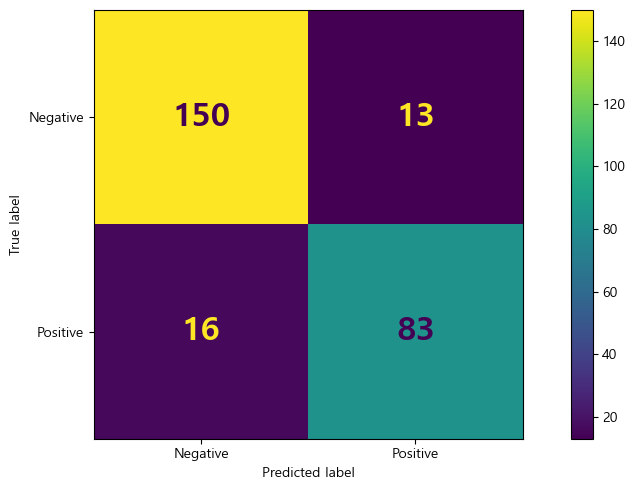


[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.
Input y contains NaN.
+----+---------+------------+------------+---------+
|    |   index | 종속변수   | 독립변수   |     VIF |
|----+---------+------------+------------+---------|
|  0 |       0 | Survived   | Pclass     |  13.374 |
|  1 |       8 | Survived   | Title      | 8.06761 |
|  2 |       6 | Survived   | FamilySize | 7.75284 |
|  3 |       3 | Survived   | Fare       | 5.71113 |
|  4 |       4 | Survived   | Embarked   | 5.05385 |
|  5 |       2 | Survived   | Age        | 5.05085 |
|  6 |       7 | Survived   | IsAlone    |   4.913 |
|  7 |       1 | Survived   | Sex        | 2.83156 |
|  8 |       5 | Survived   | Has_Cabin  | 2.23078 |
+----+---------+------------+------------+---------+


{'SVC': SVC(n_jobs=-1, random_state=1234),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=1234),
 'GaussianNB': GaussianNB(),
 'LogisticRegression': LogisticRegression(C=1, max_iter=1000, n_jobs=1, random_state=1234),
 'KNeighborsClassifier': KNeighborsClassifier(metric='manhattan', n_jobs=-1),
 'SGDClassifier': SGDClassifier(alpha=0.01, early_stopping=True, eta0=0.5,
               learning_rate='adaptive', max_iter=5000, n_jobs=-1,
               penalty='elasticnet', random_state=1234),
 'best': SVC(n_jobs=-1, random_state=1234)}

In [16]:
my_classification(x_train, y_train, x_test, y_test)

> Pclass에 대해 다중공선성 문제가 발견되었다. 해당 변수를 제거하고 다시 분석을 시도한다.

## #04. 다중공선성 제거

LogisticRegression({'n_jobs': -1, 'random_state': 1234}) {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000]}
KNeighborsClassifier({'n_jobs': -1}) {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
SVC({'n_jobs': -1, 'random_state': 1234}) {}
GaussianNB({}) {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
DecisionTreeClassifier({'random_state': 1234}) {'criterion': ['gini', 'entropy']}
SGDClassifier({'n_jobs': -1, 'random_state': 1234, 'early_stopping': True}) {'loss': ['hinge', 'log_loss', 'modified_huber'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 2000, 3000, 4000, 5000], 'learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'], 'eta0': [0.01, 0.1, 0.5]}
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----

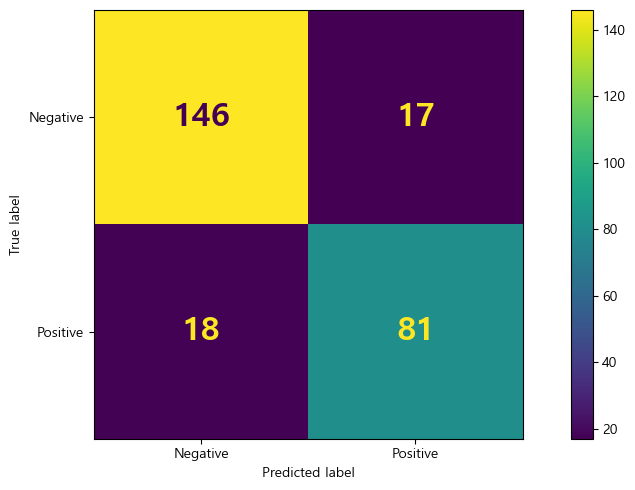

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


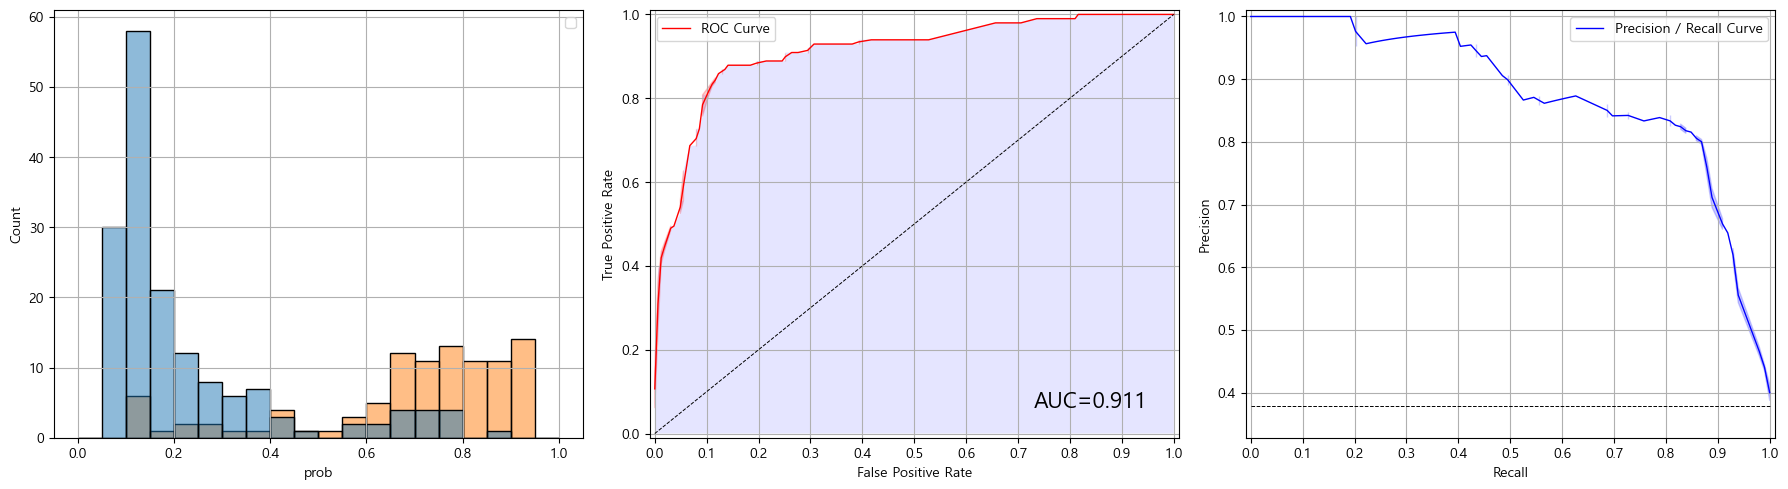


[학습곡선]


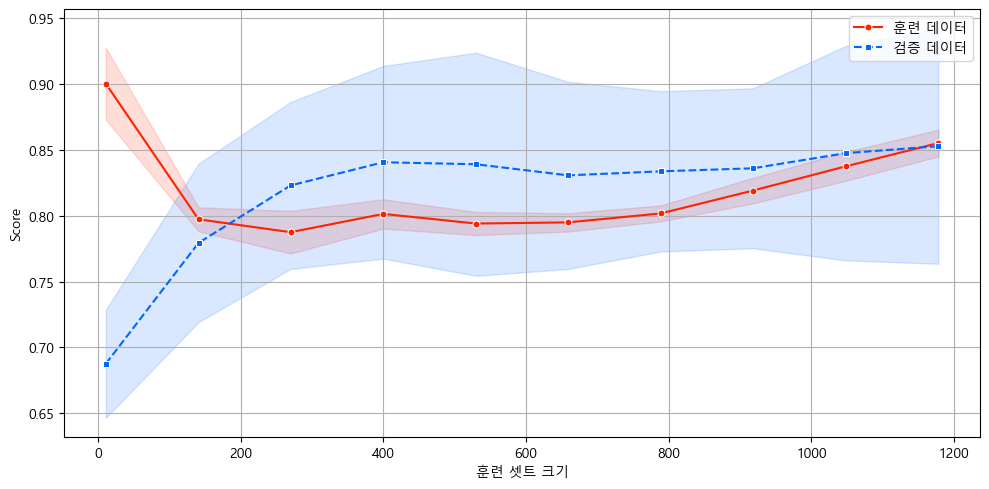

+----+---------+------------+------------+--------------------+------------+---------+------------+---------+------------+
|    |   index | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |       t |   유의확률 |     VIF |   OddsRate |
|----+---------+------------+------------+--------------------+------------+---------+------------+---------+------------|
|  0 |       7 | Survived   | Title      |            -0.1972 |      0.223 | -0.8837 |      0.377 | 7.10244 |      0.821 |
|  1 |       2 | Survived   | Fare       |             0.4601 |      0.208 |  2.2112 |      0.027 | 5.22027 |     1.5843 |
|  2 |       1 | Survived   | Age        |             -0.176 |      0.239 | -0.7372 |      0.461 | 5.00896 |     0.8386 |
|  3 |       3 | Survived   | Embarked   |            -0.1205 |      0.208 |  -0.578 |      0.563 | 4.64867 |     0.8865 |
|  4 |       5 | Survived   | FamilySize |            -0.2801 |      0.164 |  -1.705 |      0.088 | 3.99131 |     0.7557 |
|  5 |       6 | Survived   | IsAlone 

{'SVC': SVC(n_jobs=-1, random_state=1234),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=1234),
 'GaussianNB': GaussianNB(),
 'KNeighborsClassifier': KNeighborsClassifier(metric='euclidean', n_jobs=-1),
 'LogisticRegression': LogisticRegression(C=0.1, max_iter=1000, n_jobs=1, random_state=1234),
 'SGDClassifier': SGDClassifier(early_stopping=True, eta0=0.5, learning_rate='adaptive',
               max_iter=5000, n_jobs=-1, penalty='l1', random_state=1234),
 'best': LogisticRegression(C=0.1, max_iter=1000, n_jobs=1, random_state=1234)}

In [17]:
df5 = df4.drop('Pclass', axis=1)
df5['Survived'] = df5['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df5, yname='Survived')
my_classification(x_train, y_train, x_test, y_test)

> 다소 정확도는 떨어졌으나 큰 차이는 없으며, 신뢰할 수 있는 독립변수만 선정되었다.
>
> 이 데이터에 대해 가장 좋은 성능을 보여준 분석모델은 LogisticRegression인 것으로 나타났다.